# Frame by Frame: The Kaleidoscopic Evolution of Cinema Over the Decades

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.linear_model import LinearRegression
import xml.etree.ElementTree as ET
import time
import json
import statsmodels.formula.api as smf
from utilities import * 
import tarfile
import math
import gzip
import os

from data_preprocessing import * 
from imdb_ratings_scraper import *
import load_functions as lf


# Load data

## Movie Summaries

In [4]:
data_folder = './data/MovieSummaries/'
(movie_metadata, character_metadata, name_clusters, plot_summaries, test_data) = \
    lf.load_movie_summaries(data_folder)

# add release year (float) to movie_metadata, extracting it from release_date
movie_metadata['release_year'] = movie_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add lowecase title to movie_metadata
movie_metadata['lowercase_title'] = movie_metadata['movie_name'].str.lower()

# add release year (float) to character_metadata, extracting it from release_date
character_metadata['release_year'] = character_metadata['release_date'].apply(lambda x: lf.extract_year(x))
# add actor birth year (float) to character_metadata, extracting it from actor_birth_date
character_metadata['actor_birth_year'] = character_metadata['actor_birth_date'].apply(lambda x: lf.extract_year(x))

Metadata for 81 741 movies, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)
10. Movie release year
11. Lowercase title

In [5]:
movie_metadata.head(1)

,wiki_movie_id,free_movie_id,movie_name,release_date,box_office_revenue,runtime,languages,countries,genres,release_year,lowercase_title
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",2001.0,ghosts of mars


Metadata for 450 669 characters aligned to the movies above, extracted from the Noverber 4, 2012 dump of Freebase:
1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID
14. Release year
15. Actor birth year

In [6]:
character_metadata.head(1)

,wiki_movie_id,free_movie_id,release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,free_character_actor_map_id,free_character_id,free_actor_id,release_year,actor_birth_year
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.62,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,2001.0,1958.0


Plot summaries of 42 303 movies extracted from the November 2, 2012 dump of English-language Wikipedia.
Each line contains the Wikipedia movie ID (which indexes into movie_metadata) followed by the summary.

In [8]:
plot_summaries.head()

,wiki_movie_id,plot
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


# Basic features analysis

## Undestanding the dataset

In [9]:
print('number of nan values in movie_metadata:')
print(movie_metadata.isna().sum())
print('\nnumber of rows in movie_metadata:',movie_metadata.shape[0])

number of nan values in movie_metadata:
wiki_movie_id             0
free_movie_id             0
movie_name                0
release_date           6902
box_office_revenue    73340
runtime               20450
languages                 0
countries                 0
genres                    0
release_year           6902
lowercase_title           0
dtype: int64

number of rows in movie_metadata: 81741


In [10]:
print('number of nan values in character_metadata:')
print(character_metadata.isna().sum())
print('\nnumber of character_metadata rows:', character_metadata.shape[0])

number of nan values in character_metadata:
wiki_movie_id                       0
free_movie_id                       0
release_date                     9995
character_name                 257875
actor_birth_date               106145
actor_gender                    45609
actor_height                   295845
actor_ethnicity                344611
actor_name                       1228
actor_age                      158113
free_character_actor_map_id         0
free_character_id              257865
free_actor_id                     815
release_year                     9995
actor_birth_year               106156
dtype: int64

number of character_metadata rows: 450669


In [11]:
print('unique values of freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id'].unique()))
print('freebase movie ID in character_metadata:',
      len(character_metadata['free_movie_id']))
print('number of movie ID in character_metadata, which appear in movie_metadata:',
      sum(movie_metadata['free_movie_id'].isin(character_metadata['free_movie_id'].unique())))

unique values of freebase movie ID in character_metadata: 64330
freebase movie ID in character_metadata: 450669
number of movie ID in character_metadata, which appear in movie_metadata: 64330


Each movie in character_metadata appears in movie_metadata

In [12]:
print('unique values of freebase character ID in character_metadata (number of characters):',
      len(character_metadata['free_character_id'].unique()))
print('unique values of freebase actor ID in character_metadata (number of actors):',
      len(character_metadata['free_actor_id'].unique()))
print('unique values of actor ethnicity in character_metadata (number of ethnicities):',
      len(character_metadata['actor_ethnicity'].unique()))

unique values of freebase character ID in character_metadata (number of characters): 183436
unique values of freebase actor ID in character_metadata (number of actors): 135761
unique values of actor ethnicity in character_metadata (number of ethnicities): 480


## Plot data

### Movies metadata

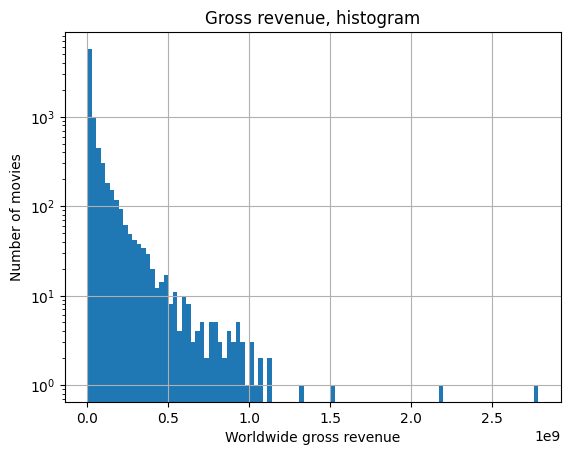

In [13]:
# gross revenue histogram
movie_metadata['box_office_revenue'].dropna().hist(bins = 100, log=True)
plt.xlabel('Worldwide gross revenue')
plt.ylabel('Number of movies')
plt.title('Gross revenue, histogram');

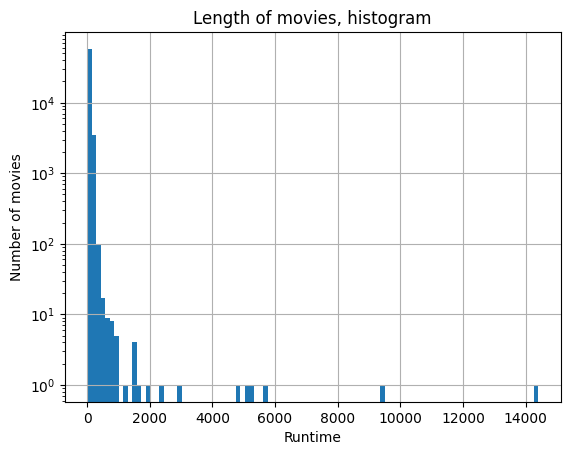

In [14]:
# runtime of movies histogram.
# We dropped movies with a length >= 1079280, as we observed errors in the dataset
movie_metadata[movie_metadata['runtime'] < 1079280].runtime.dropna().hist(bins = 100, log=True)
plt.xlabel('Runtime')
plt.ylabel('Number of movies')
plt.title('Length of movies, histogram');

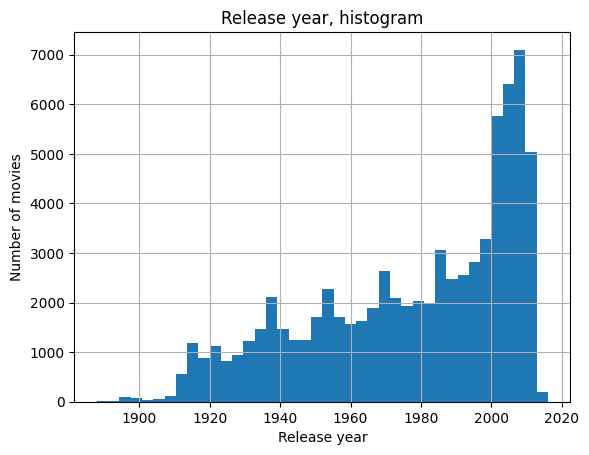

In [15]:
# release year histogram. We dropped movies with a release year <= 1011,
# We dropped movies with a release year <= 1011, as we observed errors in the dataset
movie_metadata[movie_metadata['release_year'] > 1011].release_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of movies')
plt.title('Release year, histogram');

The distribution is very skewed with the big majority of movies after 2000

### Characters metadata

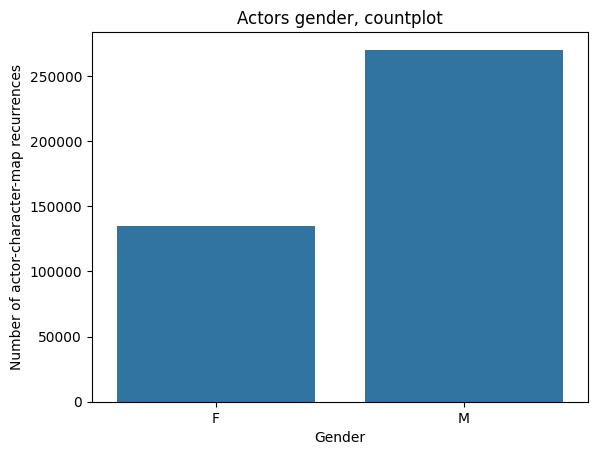

In [16]:
# actor gender countplot
sns.countplot(data=character_metadata, x="actor_gender");
plt.title('Actors gender, countplot')
plt.xlabel('Gender')
plt.ylabel('Number of actor-character-map recurrences');

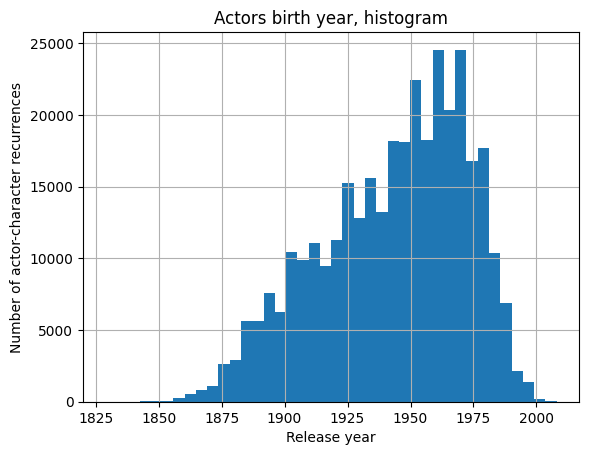

In [17]:
# actor birth year, histogram
# We dropped actors with a birth year <= 1828 or >= 2009, as we observed errors in the dataset
character_metadata[(character_metadata['actor_birth_year'] > 1828) * (character_metadata['actor_birth_year'] < 2009)].actor_birth_year.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors birth year, histogram');

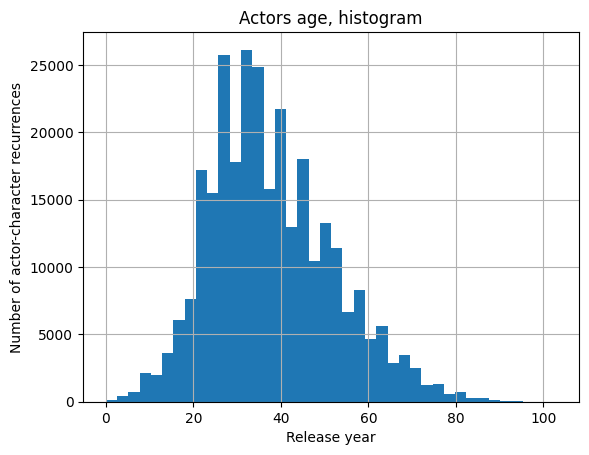

In [18]:
# actor age histogram
# We dropped actors with an age < 0, as we observed errors in the dataset
character_metadata[character_metadata['actor_age'] >= 0].actor_age.dropna().hist(bins = 40, log=False)
plt.xlabel('Release year')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actors age, histogram');

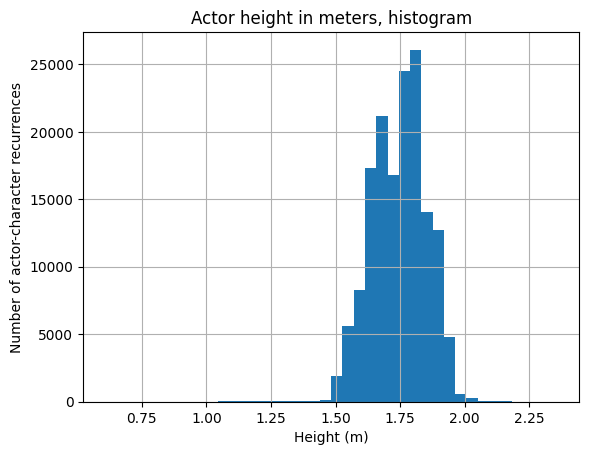

In [19]:
# actor height histogram
# We dropped actors with a height >= 3, as we observed errors in the dataset
character_metadata[character_metadata['actor_height'] < 3].actor_height.dropna().hist(bins = 40, log=False)
plt.xlabel('Height (m)')
plt.ylabel('Number of actor-character recurrences')
plt.title('Actor height in meters, histogram');

# Exploring how characteristic of most popular movies changed over time

In [3]:
# loading the two dataset downloaded from imdb
movies_info = pd.read_csv('data/movies_imdb_ids.csv')
movies_review = pd.read_csv('data/title_ratings_tsv.tsv', sep = '\t')

movies_info_ratings = movies_info.merge(movies_review, how = 'inner', on= 'tconst')
movies_info_ratings['year'] = pd.DatetimeIndex(movies_info_ratings['release date']).year  # extracting year
movies_info_ratings = movies_info_ratings[movies_info_ratings.year < 2012]

In [4]:
# these are the columns we have
movies_info_ratings.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Wikipedia movie ID', 'Freebase movie ID',
       'name', 'release date', 'box office revenue', 'runtime', 'languages',
       'countries', 'genres_x', 'tconst', 'titleType', 'primaryTitle',
       'originalTitle', 'isAdult', 'startYear', 'endYear', 'runtimeMinutes',
       'genres_y', 'averageRating', 'numVotes', 'year'],
      dtype='object')

In this and the following plots we'll only consider the 25 most popular movies for every year. These were selected by ranking movies every year by the number of votes on IMDB. Here we aren’t taking the ratings into account, what we were trying to estimate with this metric is how many people have watched the movie. 

/home/stefano/Documents/EPFL/ada_course/ada-2023-project-msosm/utilities.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95,)


Text(0.5, 1.0, 'Temporal Evolution of Runtimes - Best 25 movies every year')

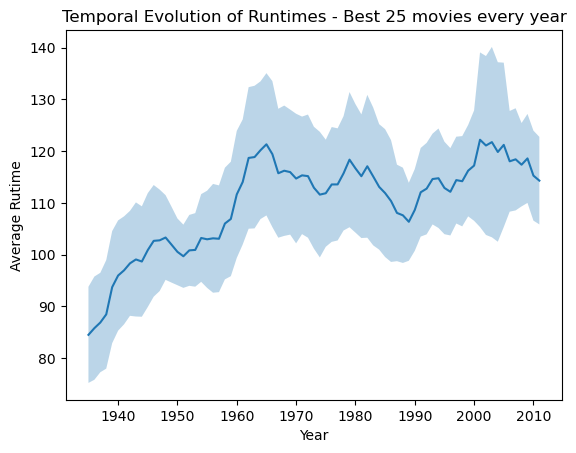

In [39]:
# how did the runtime changed over time? 
plot_25_movies_through_time(movies_info_ratings, 'runtime')
plt.ylabel('Average Rutime')
plt.title('Temporal Evolution of Runtimes - Best 25 movies every year')

Did movies get longer in the last years? They increased until the 60s, than had a small decline until the 90s maybe due to videocassete and other contraints as movies weren't projected only in cinemas anymore. From the 90s onward we see a steady increase probably due to newer technology. 

/home/stefano/Documents/EPFL/ada_course/ada-2023-project-msosm/utilities.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95,)


Text(0.5, 1.0, 'Temporal evolution of IMDB Rating - Best 25 movies every year')

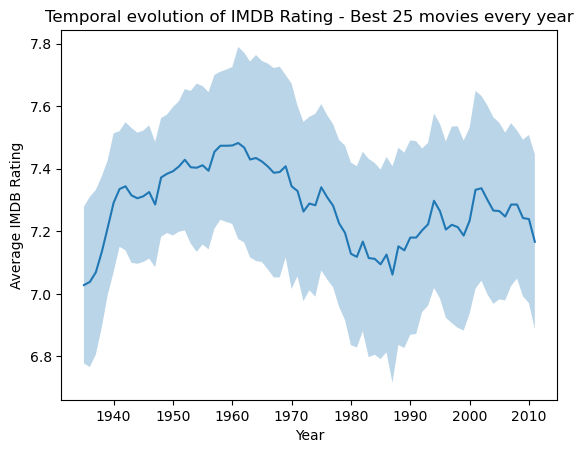

In [43]:
# how did the imdb rating changed for movies published in different years
plot_25_movies_through_time(movies_info_ratings, 'averageRating')
plt.ylabel('Average IMDB Rating')
plt.title('Temporal evolution of IMDB Rating - Best 25 movies every year')

In [5]:
# adjust budget by inflation, dataset taken from https://fred.stlouisfed.org/series/CPIAUCSL

# loading movies' budget
metadata_df = pd.read_csv('data/movies.csv')

# joining with previous dataframe
metadata_df.name = metadata_df.name.str.lower()
movies_info_ratings.name = movies_info_ratings.name.str.lower()
movies_info_ratings_merged = metadata_df.merge(movies_info_ratings, 'inner', on=['name', 'year'])

cpi_over_time = pd.read_csv('data/CPIAUCSL.csv')
# compute the inflation rate for every year compared to today
cpi_over_time['adjustment'] = cpi_over_time['CPIAUCSL'].iloc[-1] / cpi_over_time['CPIAUCSL']
cpi_over_time['date'] = pd.to_datetime(cpi_over_time.DATE, utc=True)
cpi_over_time['year'] = cpi_over_time['date'].apply(lambda x : x.year)
# group the inflation rate per year
cpi_over_time = cpi_over_time.groupby('year').mean()

# merge with previously loaded dataset
importance_over_time_df_adjusted = movies_info_ratings_merged.merge(cpi_over_time, 'inner', on='year').copy()
# multiply the budget by inflation rate in order to get inflation adjusted budget
importance_over_time_df_adjusted['adjusted_budget'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted.budget
# same for box office revenue
importance_over_time_df_adjusted['adjusted_box_office_revenue'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted['box office revenue']

/tmp/ipykernel_21828/4227768411.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[1])
/tmp/ipykernel_21828/4227768411.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[0])


Text(0.5, 1.0, 'Budget')

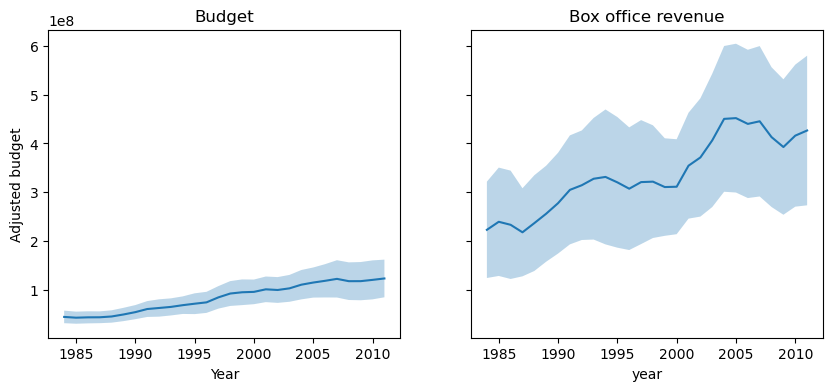

In [7]:
# # how did the average budjet of movies changed through the years? 

f, axes = plt.subplots(1, 2, sharey=True, figsize= (10, 4))

df = importance_over_time_df_adjusted

feature = 'adjusted_box_office_revenue'
# how did the adjusted box office of movies changed through the years? 
sorted_movie_data = df.sort_values(by=['year', 'numVotes'], ascending=[True, False])

# Use groupby to keep the top 25 movies for each year
top_25_movies = sorted_movie_data.groupby('year').head(25)
top_25_movies = top_25_movies[top_25_movies.year > 1930]

window_size = 5
top_25_movies_grouped = top_25_movies.groupby('year').mean()[feature].rolling(window=window_size).mean()
top_25_movies_grouped_std = top_25_movies.groupby('year').std()[feature].rolling(window=window_size).mean()

# Plotting the data with a regression line and confidence interval
sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[1])

lower_bound = top_25_movies_grouped - top_25_movies_grouped_std * 1.96 / 5
upper_bound = top_25_movies_grouped + top_25_movies_grouped_std * 1.96  / 5
axes[1].fill_between(top_25_movies_grouped.index, lower_bound, upper_bound, alpha=.3)


axes[1].set_ylabel('Adjusted box office revenue')
plt.title('Box office revenue')



# plot_25_movies_through_time(importance_over_time_df_adjusted, 'adjusted_budget')
feature = 'adjusted_budget'
df = importance_over_time_df_adjusted

sorted_movie_data = df.sort_values(by=['year', 'numVotes'], ascending=[True, False])

# Use groupby to keep the top 25 movies for each year
top_25_movies = sorted_movie_data.groupby('year').head(25)
top_25_movies = top_25_movies[top_25_movies.year > 1930]

window_size = 5
top_25_movies_grouped = top_25_movies.groupby('year').mean()[feature].rolling(window=window_size).mean()
top_25_movies_grouped_std = top_25_movies.groupby('year').std()[feature].rolling(window=window_size).mean()

# Plotting the data with a regression line and confidence interval
sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95, ax = axes[0])

lower_bound = top_25_movies_grouped - top_25_movies_grouped_std * 1.96 / 5
upper_bound = top_25_movies_grouped + top_25_movies_grouped_std * 1.96  / 5
axes[0].fill_between(top_25_movies_grouped.index, lower_bound, upper_bound, alpha=.3)

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Adjusted budget')
axes[0].set_title('Budget')
# # plt.ylim((1, 6))



/home/stefano/Documents/EPFL/ada_course/ada-2023-project-msosm/utilities.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(x='year', y=feature, data=pd.DataFrame(top_25_movies_grouped), ci=95,)


Text(0.5, 1.0, 'Temporal evolution of adjusted box office revenue\nBest 25 movies every year')

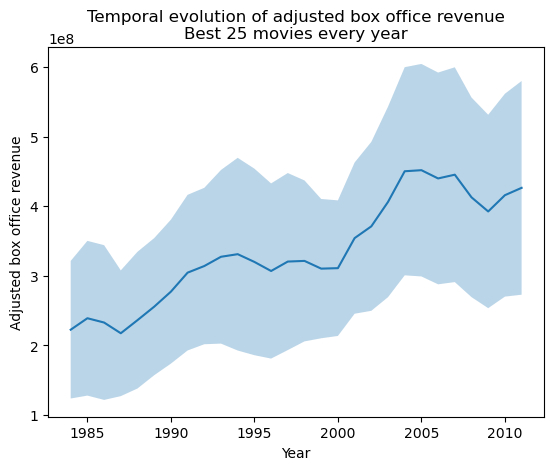

In [46]:
# how did the adjusted box office of movies changed through the years? 
plot_25_movies_through_time(importance_over_time_df_adjusted, 'adjusted_box_office_revenue')
plt.ylabel('Adjusted box office revenue')
plt.title('Temporal evolution of adjusted box office revenue\nBest 25 movies every year')

# Plot evolution and similarity


In [20]:
from similarity_and_evolution import preprocess_text, cosine_similarity

plot_similarity = plot_summaries
plot_evolution = plot_summaries
plot_similarity['count_words'] = plot_similarity.apply(lambda x: len(str(x['plot']).split()), axis=1)

# Drop plots with less than 200 words
plot_similarity.drop(plot_similarity[plot_similarity['count_words'] < 200].index, inplace= True)

# Preprocess the synopses
# The Hunger Games
preprocessed_synopsis1 = preprocess_text(plot_similarity.query("wiki_movie_id == 31186339").iloc[0]['plot'])

# Fast and Furious: Tokyo Drift
preprocessed_synopsis2 = preprocess_text(plot_similarity.query("wiki_movie_id == 2913859").iloc[0]['plot'])

# Harry Potter: Deathly Hallows Part I
preprocessed_synopsis3 = preprocess_text(plot_similarity.query("wiki_movie_id == 9834441").iloc[0]['plot'])

# Mamma mia
preprocessed_synopsis4 = preprocess_text(plot_similarity.query("wiki_movie_id == 8425661").iloc[0]['plot'])

Compute cosine similarity between preprocessed plots

In [21]:
similarity_1 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis2)
similarity_2 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis3)
similarity_3 = cosine_similarity(preprocessed_synopsis1, preprocessed_synopsis4)
similarity_4 = cosine_similarity(preprocessed_synopsis3, preprocessed_synopsis4)

### Cosine similarity interpretation and validation
If cosine similarity is equal to 1 means both plots are identical. On the other side, if cosine similarity is equal to 0 means the plots have nothing in common.

Overviewing the below similarities, it makes sense that "The Hunger Games" is more similar to a film such as "Harry Potter: Deathly Hallows Part 1" for more common actions such as "kill", "reveal" and "take" than to Fast&Furious and Mamma Mia. This actions may appear also in the latter movies but with less relevance.

And unusual phenomena is observed when comparing Harry Potter to Mamma Mia. Using the user's experience, one can argue these films are not very much alike. Investigating the issue further, we discover that this high value on similarity is due to one of the main protagonist for both films are called Harry.

Filtering people's name might be necessary to refine the algorithm.

In [22]:
print(f"Cosine Similarity The Hunger Games - F&F:Tokyo Drift: {similarity_1}")
print(f"Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: {similarity_2}")
print(f"Cosine Similarity The Hunger Games - Mamma mia: {similarity_3}")
print(f"Cosine Similarity HP: Death Hollows P1 - Mamma mia: {similarity_4}")

Cosine Similarity The Hunger Games - F&F:Tokyo Drift: 0.029112649379961022
Cosine Similarity The Hunger Games - HP: Deathly Hallows P1: 0.0582765471839679
Cosine Similarity The Hunger Games - Mamma mia: 0.029958426421823198
Cosine Similarity HP: Death Hollows P1 - Mamma mia: 0.033301144786951474


### Similarity computation by year
We are interested on how much similar are movies released on the same year are alike

In [23]:
plot_similarity_enriched = pd.merge(plot_similarity, movie_metadata[['movie_name','release_year','wiki_movie_id']], on="wiki_movie_id",how='left')
plot_similarity_enriched.head()

,wiki_movie_id,plot,count_words,movie_name,release_year
0,31186339,The nation of Panem consists of a wealthy Capi...,778,The Hunger Games,2012.0
1,20663735,Poovalli Induchoodan is sentenced for six yea...,496,Narasimham,2000.0
2,2231378,"The Lemon Drop Kid , a New York City swindler,...",849,The Lemon Drop Kid,1951.0
3,595909,Seventh-day Adventist Church pastor Michael Ch...,397,A Cry in the Dark,1988.0
4,5272176,The president is on his way to give a speech. ...,344,End Game,2006.0


In [24]:
#similarity_by_year = plot_similarity_enriched.groupby('release_year')
#for year, group in similarity_by_year:
#    for idx, row in group.iterrows():
#        preprocessed_text = preprocess_text(row['plot'])
#        print(preprocessed_text)

### Emotional arc

An interesting aspect of a movie is its emotional arc. We give a sentiment value to each sentence in the plot summary and then interpret the sequence of sentiment values of the sentences as the movie's emotional arc.

In [25]:
from similarity_and_evolution import tokenize_per_sentence
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# The Hunger Games, tokenized per sentence
plot_per_sentence1 = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 31186339").iloc[0]['plot'])
# Fast and Furious: Tokyo Drift, tokenized per sentence
plot_per_sentence2 = tokenize_per_sentence(plot_evolution.query("wiki_movie_id == 2913859").iloc[0]['plot'])

In [26]:
analyzer = SentimentIntensityAnalyzer()
"""
    This function computes the sentiment value of each sentence in the plot, and returns all of them as a list.
"""
def compute_sentiment_sequence(plot_sentences):
    sentiment_sequence = []
    for sentence in plot_sentences:
        sentiment_sequence.append(analyzer.polarity_scores(sentence)['compound'])
    return sentiment_sequence

Text(0, 0.5, 'sentiment value')

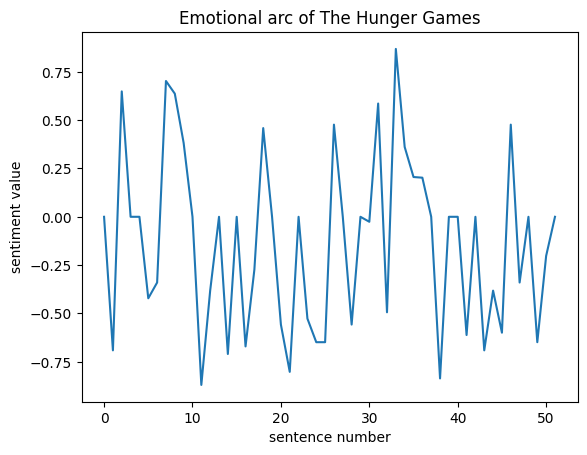

In [49]:
# plot the sentiment value sequence, i.e emotional arc, of the Hunger Games
emotional_arc1 = compute_sentiment_sequence(plot_per_sentence1)
plt.plot(emotional_arc1)
plt.title("Emotional arc of The Hunger Games")
plt.xlabel("sentence number")
plt.ylabel("sentiment value")

To take the average over different emotional arcs of movies, there is one problem. They are of different length. We circumvent this problem by normalizing all emotional arcs to one length, namely the average length of all emotional arcs.

Text(0, 0.5, 'sentiment value')

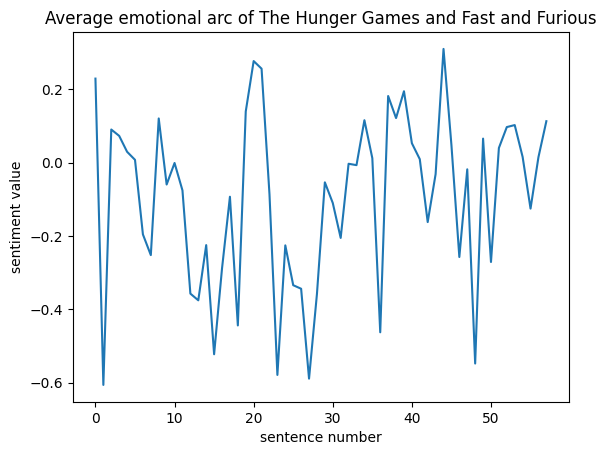

In [50]:
from scipy.interpolate import interp1d
import statistics
# compute emotional arc of Fast and Furious
emotional_arc2 = compute_sentiment_sequence(plot_per_sentence2)

# compute the length to which we normalize both sequences as the average of the two lengths
normalized_length = round(sum([len(emotional_arc1), len(emotional_arc2)])/2)

# normalize both sequences to this lenght using interpolation
interpolate1 = interp1d(np.linspace(0, 1, len(emotional_arc1)), emotional_arc1)
interpolate2 = interp1d(np.linspace(0, 1, len(emotional_arc2)), emotional_arc2)
emotional_arc2_norm = interpolate2(np.linspace(0, 1, normalized_length))
emotional_arc1_norm = interpolate1(np.linspace(0, 1, normalized_length))

# compute average emotional arc over these two movies
average_emotional_arc = np.mean([emotional_arc1_norm, emotional_arc2_norm], axis=0)
plt.plot(average_emotional_arc)
plt.title("Average emotional arc of The Hunger Games and Fast and Furious")
plt.xlabel("sentence number")
plt.ylabel("sentiment value")

As we can see that the emotional arcs is not smooth at all, we will still have to apply some smoothing to them to make them more interpretable.

## How do movies age? Comparing ratings after one and five years

We wanted to better understand which characteristics make a movie age well (i.e. become more popular as years go by) or make people forget about it after a few months. 
To evaluate this, we required a metric to gauge how the qualities of movies changed over the years. We utilized the Way Back Machine (https://web.archive.org/) a web archive with periodic snapshots of all the majorly visited web pages on the internet. The folowing is the script for scraping the IMDB pages. 


In [15]:
# only run if want to scrpae new data 
number_elements_to_scrape = len(res)

ratings_df = pd.DataFrame()

for index, row in res.iloc[:number_elements_to_scrape].iterrows():

    print(f"{index}/{number_elements_to_scrape} scraped -- Now scraping {row['tconst']}", end = '\r')

    try: 
        dates, ratings, num_voters = scraper_review_next_and_five_years(row['tconst'], row['release date'])
        ratings.extend(num_voters)
        df = pd.DataFrame([ratings], columns=['after_one_year_rating', 'after_five_year_rating', 'one_year_num_voters', 'five_year_num_voters',], index = [row['tconst']])
        ratings_df = pd.concat([df, ratings_df],  sort=False)
    except Exception as e: 
        print(f"Exception {e}")  # handling all excpetion in order to not sto pscraping process

# print(result_df.head())
ratings_df.to_csv('data/imbd_ratings.csv') # save scraped for future use

In [16]:
# load merged dataset with imdb ids and movie metadata
# imdb ids will be necessary to later merge with the scraped ratings
importance_over_time_df = pd.read_csv('data/movies_imdb_ids.csv')

importance_over_time_df['release date'] = pd.to_datetime(importance_over_time_df['release date'], format='%Y-%m-%d', errors='coerce') # convert to datetime format
importance_over_time_df = importance_over_time_df.loc[importance_over_time_df['release date']  > datetime(2004, 1, 1)].copy()  # only consider dates after 2004 (before imdb didn't exist)
importance_over_time_df = importance_over_time_df.loc[importance_over_time_df['box office revenue'].notna()].copy() # remove ones without box office revenue
importance_over_time_df.reset_index(inplace=True, drop=True)
importance_over_time_df = importance_over_time_df.loc[:, ~importance_over_time_df.columns.str.contains('^Unnamed')]  # dropping unnamed columns

In [17]:
ratings_df = pd.read_csv('data/imbd_ratings.csv')  # load the dataset with the scraped ratings
ratings_df = ratings_df.set_index(ratings_df.iloc[:, 0])
ratings_df = ratings_df.loc[:, ~ratings_df.columns.str.contains('^Unnamed')] 

# merge scraped ratings with the provided dataset
ratings_metadata = importance_over_time_df.merge(ratings_df, how ='right', left_on='tconst', right_index=True)

In [18]:
# this dataset contains the budget and other important features which weren't availible in the original dataset
metadata_df = pd.read_csv('data/movies.csv')

metadata_df.name = metadata_df.name.str.lower()
ratings_metadata.name = ratings_metadata.name.str.lower()

ratings_metadata = ratings_metadata.merge(metadata_df, 'inner', on='name')
ratings_metadata.head(2)

,Wikipedia movie ID,Freebase movie ID,name,release date,box office revenue,runtime_x,languages,countries,genres_x,tconst,...,score,votes,director,writer,star,country,budget,gross,company,runtime_y
0,25920477,/m/0b6lqyd,source code,2011-03-11,147332697.0,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/0f8l9c"": ""France"", ""/m/09c7w0"": ""United S...","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",tt0945513,...,7.5,495000.0,Duncan Jones,Ben Ripley,Jake Gyllenhaal,United States,32000000.0,147332697.0,Summit Entertainment,93.0
1,10149834,/m/02q3fdr,ponyo,2008-07-19,202614288.0,101.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/0gw5n2f"": ""Japanese Movies"", ""/m/03k9fj"":...",tt0876563,...,7.7,131000.0,Hayao Miyazaki,Hayao Miyazaki,Cate Blanchett,Japan,34000000.0,204826668.0,Studio Ghibli,101.0


In [19]:
# loading characters information as they migth be useful for predicting movies aging
characters_meta = pd.read_csv('data/MovieSummaries/character.metadata.tsv', sep='\t', header=None,)
characters_meta.columns = ['Wikipedia Movie ID', 'Freebase Movie ID', 'movie release date', 'Character Name', 'Actor DOB',  'Actor gender', 'Actor height', 'Actor ethnicity', 'Actor Name', 'Actor age at movie release', 'Freebase character map', 'boh', 'boh1']

# extracting numerical information from the characters metadata
movie_stats = characters_meta.groupby("Freebase Movie ID").agg( 
    num_actors=pd.NamedAgg(column="Actor Name", aggfunc="nunique"), # numerber of actors
    avg_age=pd.NamedAgg(column="Actor age at movie release", aggfunc="mean"),   # mean age
    gender_percent=pd.NamedAgg(column="Actor gender", aggfunc=lambda x: (x == "F").sum() / len(x) * 100)  # gender ration
).reset_index()

# merging new features to the old dataset
ratings_metadata = ratings_metadata.merge(movie_stats, 'inner', left_on='Freebase movie ID', right_on='Freebase Movie ID')

In [20]:
# many values in the dataset are saved in a dictionary, the following function allows to extract them
def get_first_value_from_dictionary(row, value):
    l = list(json.loads(row[value]).values())
    if len(l) > 0: 
        genres = l[0]
    else: 
        genres = ''
    return genres

def count_dictionary(row, value): 
    return len(json.loads(row[value]).keys())


In [21]:

# extract first genre (most important), language and first conuntry
ratings_metadata["genre"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["language"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
ratings_metadata["country"] = ratings_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
# extracting year from date
ratings_metadata['year'] = pd.DatetimeIndex(ratings_metadata['release date']).year  

# counting the number of genre, languages and countries
ratings_metadata["n_genre"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'genres_x'), axis=1)
ratings_metadata["n_language"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
ratings_metadata["n_country"] = ratings_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

# encoding title type, company name and which actor was the star of the movie as categorical features
ratings_metadata["titleType"] = ratings_metadata['titleType'].apply(lambda x : x if x == 'movie' or x == 'short' or x == 'tvSeries' else 'movie')
one_hot_encoded = pd.get_dummies(ratings_metadata['titleType'], prefix='titleType')

# Concatenate the one-hot-encoded columns to the original DataFrame
ratings_metadata = pd.concat([ratings_metadata, one_hot_encoded], axis=1)
ratings_metadata['company'] = ratings_metadata['company'].astype('category').cat.codes
ratings_metadata['star'] = ratings_metadata['star'].astype('category').cat.codes
ratings_metadata['genre_code'] = ratings_metadata['genre'].astype('category').cat.codes
ratings_metadata['language_code'] = ratings_metadata['language'].astype('category').cat.codes
ratings_metadata['country_code'] = ratings_metadata['country'].astype('category').cat.codes

# converting runtime to numeric while dropping the string without the correct format
ratings_metadata['runtimeMinutes'] = pd.to_numeric(ratings_metadata.runtimeMinutes, errors='coerce')

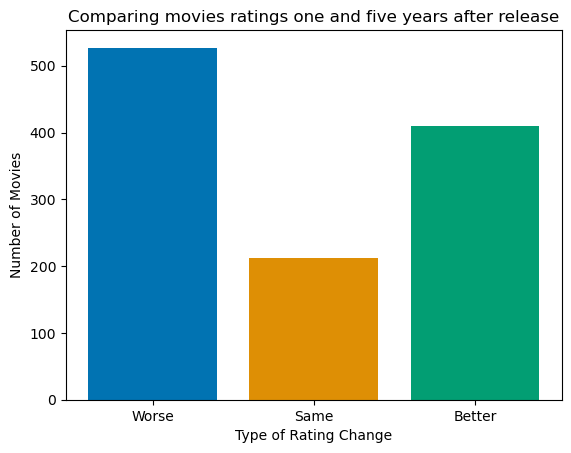

In [22]:
import matplotlib.pyplot as plt

# Assuming you have already calculated ratings_difference
ratings_metadata['ratings_difference'] = ratings_metadata.after_five_year_rating - ratings_metadata.after_one_year_rating

# Count the occurrences of 'worse', 'same', 'better'
count_worse = (ratings_metadata['ratings_difference'] < 0).sum()
count_same = (ratings_metadata['ratings_difference'] == 0).sum()
count_better = (ratings_metadata['ratings_difference'] > 0).sum()

colors = sns.color_palette('colorblind')
plt.bar(['Worse', 'Same', 'Better'], height=[count_worse, count_same, count_better], color=colors)


# Adding labels and title
plt.xlabel('Type of Rating Change')
plt.ylabel('Number of Movies')
plt.title('Comparing movies ratings one and five years after release')

# Show the plot
plt.show()


/tmp/ipykernel_21828/2626963110.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ratings_metadata.fillna(ratings_metadata.mean())
/tmp/ipykernel_21828/2626963110.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  ratings_metadata.fillna(ratings_metadata.mean())


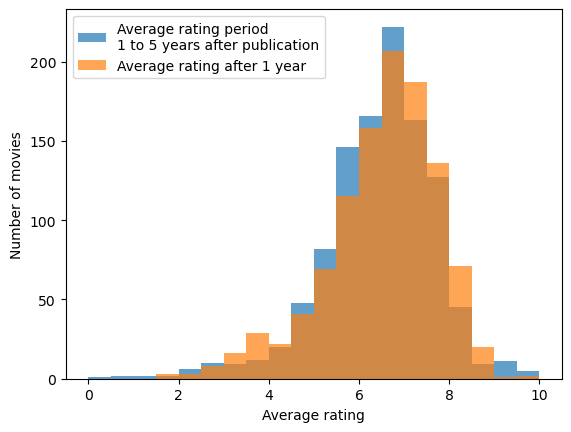

In [23]:
ratings_metadata.fillna(ratings_metadata.mean())

# we'll regres on the average rating in the period from one to five years after publication               
diff_num_voters = ratings_metadata.five_year_num_voters -  ratings_metadata.one_year_num_voters
weigthed_five_years_ratings = ratings_metadata.after_five_year_rating * ratings_metadata.five_year_num_voters
weigthed_one_years_ratings = ratings_metadata.after_one_year_rating * ratings_metadata.one_year_num_voters

# compute the average rating in the period
ratings_metadata['ratings_one_five']  =  (weigthed_five_years_ratings - weigthed_one_years_ratings) / diff_num_voters

# fill missing values
ratings_metadata.ratings_one_five = ratings_metadata.ratings_one_five.fillna(ratings_metadata.ratings_one_five.mean())
ratings_metadata.reset_index(drop=True, inplace=True)

# 
ratings_metadata = ratings_metadata.loc[(ratings_metadata.ratings_one_five != math.inf) & (ratings_metadata.ratings_one_five != -math.inf)]
ratings_metadata = ratings_metadata[(ratings_metadata.ratings_one_five <= 10) & (ratings_metadata.ratings_one_five > 0)]
# plt.hist(ratings_metadata.ratings_one_five, bins = 20, label = 'Average rating period \n1 to 5 years after publication', alpha=0.7)
# plt.hist(ratings_metadata.after_one_year_rating, bins = 20, label = 'Average rating after 1 year', alpha=0.7)

_, bins, _ = plt.hist(ratings_metadata.ratings_one_five, bins=20, range=[0, 10], label = 'Average rating period \n1 to 5 years after publication', alpha = 0.7)
_ = plt.hist(ratings_metadata.after_one_year_rating, bins=bins, alpha=0.7, label = 'Average rating after 1 year')

plt.xlabel('Average rating')
plt.ylabel('Number of movies')
plt.legend()

We can already make some intresting observations. Ratings after one year tend to be slightly higher than the average rating from one to five years. People often have a positive perception of new things, thus it's natural that the recent blockbuster will be more hyped and better reviewed. Things changes one year after the movie's release. 

In [24]:
# Let's do some regression analysis
# df = ratings_metadata[['ratings_one_five' , 'year' , 'after_one_year_rating' , 'runtimeMinutes']].copy()

y = ratings_metadata['ratings_one_five']
X = ratings_metadata.select_dtypes(include=['number'])
X.drop(['ratings_one_five', 'ratings_difference', 'five_year_num_voters', 'after_five_year_rating', 'votes', 'score', 'runtime_x', 'runtime_y'], axis=1, inplace=True)

X = (X - X.mean()) / X.std()
X.fillna(X.mean(), inplace=True)
X = sm.add_constant(X)

# mod = smf.ols(formula='ratings_one_five ~ year + after_one_year_rating + runtimeMinutes + year * after_one_year_rating', data=df)
mod = sm.OLS(y, X)
results = mod.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:       ratings_one_five   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.509
Method:                 Least Squares   F-statistic:                     52.28
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          3.42e-152
Time:                        17:09:08   Log-Likelihood:                -1393.2
No. Observations:                1088   AIC:                             2832.
Df Residuals:                    1065   BIC:                             2947.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     6.43

In this second regression we utilized the average rating from 1 to 5 years that was computed above. The R-square in this case is 0.522, which is acceptable given the complexity of dependent variable we're trying fit. Many features have a high p-value and thus they won't be considered in the analysis of the results. The following are some of the conclusion that can be draws from the regression: 
- The aging of movie (in this case characterize by the average review in the period from one to five year after the release), highly depends on the reviews after one year (p=0.000 t=29.706).
- Adult movies age tend also to age better. 
- Short age worse than others while TV series age better. This makes sense becasuse TV series are trasmitted for a longer period of time, thus in the period from one to five years from when the first episode newer episodes might still be coming out which might have the same effect of a movie release. 

Naturally causation cannot be infered for this, we can only make claims about correlation. 

# Which are the most important features to preict the revenue of a movie? How do they change through the years? 

In [25]:
# load provided dataset 
movies_metadata = pd.read_csv('data/movie.metadata.tsv', sep='\t', header=None)
# name columsn based on documentation
movies_metadata.columns = ['wiki id', 'free base id', 'name', 'release date', 'box office revenue', 'runtime', 'languages', 'countries', 'genres']

# parse release date
movies_metadata['release date'] = pd.to_datetime(movies_metadata['release date'], format='%Y-%m-%d', errors='coerce') # convert to datetime format
movies_metadata = movies_metadata.loc[movies_metadata['box office revenue'].notna()].copy() # remove ones without box office revenue
movies_metadata.reset_index(inplace=True, drop=True)

# extracting values from dictionaries 
movies_metadata["genre"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'genres'), axis=1)
movies_metadata["language"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'languages'), axis=1)
movies_metadata["country"] = movies_metadata.apply(lambda row: get_first_value_from_dictionary(row, 'countries'), axis=1)
movies_metadata['year'] = pd.DatetimeIndex(movies_metadata['release date']).year  # extracting year

# count number of genre, language and countries
movies_metadata["n_genre"] = movies_metadata.apply(lambda row: count_dictionary(row, 'genres'), axis=1)
movies_metadata["n_language"] = movies_metadata.apply(lambda row: count_dictionary(row, 'languages'), axis=1)
movies_metadata["n_country"] = movies_metadata.apply(lambda row: count_dictionary(row, 'countries'), axis=1)

movies_metadata.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime,languages,countries,genres,genre,language,country,year,n_genre,n_language,n_country
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,English Language,United States of America,2001.0,7,1,1


In [26]:
# this dataset contains the budget and other important features which weren't availible in the original dataset
metadata_df = pd.read_csv('data/movies.csv')

metadata_df.name = metadata_df.name.str.lower()
movies_metadata.name = movies_metadata.name.str.lower()

movies_metadata = movies_metadata.merge(metadata_df, 'inner', on=['name', 'year'])
movies_metadata['name'] = movies_metadata['name'].astype('category').cat.codes
movies_metadata['company'] = movies_metadata['company'].astype('category').cat.codes
movies_metadata['star'] = movies_metadata['star'].astype('category').cat.codes

movies_metadata.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime_x,languages,countries,genres,genre_x,...,score,votes,director,writer,star,country_y,budget,gross,company,runtime_y
0,975900,/m/03vyhn,1317,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,...,4.9,52000.0,John Carpenter,Larry Sulkis,1124,United States,28000000.0,14010832.0,1038,98.0


In [27]:
# adjust budget by inflation, dataset taken from https://fred.stlouisfed.org/series/CPIAUCSL
cpi_over_time = pd.read_csv('data/CPIAUCSL.csv')
# compute the inflation rate for every year compared to today
cpi_over_time['adjustment'] = cpi_over_time['CPIAUCSL'].iloc[-1] / cpi_over_time['CPIAUCSL']  
cpi_over_time['date'] = pd.to_datetime(cpi_over_time.DATE, utc=True)
cpi_over_time['year'] = cpi_over_time['date'].apply(lambda x : x.year)
# group the inflation rate per year
cpi_over_time = cpi_over_time.groupby('year').mean()

# merge with previously loaded dataset
importance_over_time_df_adjusted = movies_metadata.merge(cpi_over_time, 'inner', on='year').copy()
# multiply the budget by inflation rate in order to get inflation adjusted budget
importance_over_time_df_adjusted['adjusted_budget'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted.budget
# same for box office revenue
importance_over_time_df_adjusted['adjusted_box_office_revenue'] = importance_over_time_df_adjusted.adjustment *  importance_over_time_df_adjusted['box office revenue']

importance_over_time_df_adjusted = importance_over_time_df_adjusted.merge(movie_stats, 'inner', left_on='free base id', right_on='Freebase Movie ID')
importance_over_time_df_adjusted.head(1)

,wiki id,free base id,name,release date,box office revenue,runtime_x,languages,countries,genres,genre_x,...,company,runtime_y,CPIAUCSL,adjustment,adjusted_budget,adjusted_box_office_revenue,Freebase Movie ID,num_actors,avg_age,gender_percent
0,975900,/m/03vyhn,1317,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science...",Thriller,...,1038,98.0,177.041667,1.737584,4.865235e+07,2.434499e+07,/m/03vyhn,17,43.461538,35.294118


In [28]:
from datetime import * 

# divide dates in group of roughly two years each
days_range = 700

start_range = datetime(1920, 1, 1)
end_range = datetime(1920, 1, 1) + timedelta(days_range)
max_date = importance_over_time_df_adjusted['release date'].max()

# only keep movies after 1920
fixed_release_date = importance_over_time_df_adjusted.loc[importance_over_time_df_adjusted['release date'] >= start_range].copy(deep = True)

# assign value year for all movies between year and year + timedelta 700 days
while start_range < max_date: 
    fixed_release_date.loc[(fixed_release_date['release date'] >= start_range) &
                                 (fixed_release_date['release date'] < end_range), ('release date')]  = start_range
    start_range = end_range
    end_range = end_range + timedelta(days_range)

In [29]:
# these are the features we have so far for this section
fixed_release_date.columns

Index(['wiki id', 'free base id', 'name', 'release date', 'box office revenue',
       'runtime_x', 'languages', 'countries', 'genres', 'genre_x', 'language',
       'country_x', 'year', 'n_genre', 'n_language', 'n_country', 'rating',
       'genre_y', 'released', 'score', 'votes', 'director', 'writer', 'star',
       'country_y', 'budget', 'gross', 'company', 'runtime_y', 'CPIAUCSL',
       'adjustment', 'adjusted_budget', 'adjusted_box_office_revenue',
       'Freebase Movie ID', 'num_actors', 'avg_age', 'gender_percent'],
      dtype='object')

The initial idea was to find which were the most relevant feature for predicting the box office revenue through the years. The only feature which reliably had a significant coefficient was the budget, so we limited our analysis to that. One interesting thing which can be concluded from the plots is that only after 2004 the budget gained a significant influence on the box office revenue, before the influence wasn't significant. To futher confirm that below are reported two regression, one on movies before 2004 and the other with movies after 2004. In the regression on the dataset year < 2004 we foudn a low R-square = 0.242, while on the dataset with year > 2004 R-quare = 0.538. This indicates that the correlation between budget and box office revenue became stronger in recent years (as the budget can explain more variance). Of course we can't conclude causation from this as there might be unmeasured counfouders. 

In [30]:
y = fixed_release_date[fixed_release_date.year < 2004].adjusted_box_office_revenue
df = fixed_release_date[fixed_release_date.year < 2004].adjusted_budget
df.fillna(df.mean(), inplace=True)
df = (df - df.mean()) / df.std()
df = sm.add_constant(df)

model = sm.OLS(y, df.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     adjusted_box_office_revenue   R-squared:                       0.242
Model:                                     OLS   Adj. R-squared:                  0.242
Method:                          Least Squares   F-statistic:                     970.9
Date:                         Fri, 22 Dec 2023   Prob (F-statistic):          3.61e-185
Time:                                 17:09:24   Log-Likelihood:                -62110.
No. Observations:                         3035   AIC:                         1.242e+05
Df Residuals:                             3033   BIC:                         1.242e+05
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/tmp/ipykernel_21828/3432583134.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


In [31]:
y = fixed_release_date[fixed_release_date.year > 2004].adjusted_box_office_revenue
df = fixed_release_date[fixed_release_date.year > 2004].adjusted_budget
df.fillna(df.mean(), inplace=True)
df = (df - df.mean()) / df.std()
df = sm.add_constant(df)

model = sm.OLS(y, df.astype(float))
results = model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:     adjusted_box_office_revenue   R-squared:                       0.538
Model:                                     OLS   Adj. R-squared:                  0.538
Method:                          Least Squares   F-statistic:                     1411.
Date:                         Fri, 22 Dec 2023   Prob (F-statistic):          2.22e-205
Time:                                 17:09:25   Log-Likelihood:                -24782.
No. Observations:                         1213   AIC:                         4.957e+04
Df Residuals:                             1211   BIC:                         4.958e+04
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

/tmp/ipykernel_21828/745455514.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


Firstly from the two regression above we noticed that we were able to fit the box office just from the budget much better movies after 2004 than movies before 2004. This hinted at the fact that budget became a much more important feature in recent years. Below we have reported the regression line with the outlier highlighted. We can conclude while before 2004 it was possible to make a successfull movie even with a low budget (there are many outliers with low budget and high box office reveneu) around 2004 there was a shift in how movies where produced and the budget became crucial for the success of the movie. 

/tmp/ipykernel_21828/2344131101.py:9: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  after.fillna(after.mean(), inplace=True)
/tmp/ipykernel_21828/2344131101.py:9: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after.fillna(after.mean(), inplace=True)
/tmp/ipykernel_21828/2344131101.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after.fillna(after.mean(), inplace=True)
/tmp/ipykernel_21828/2344131101.py:34: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=Non

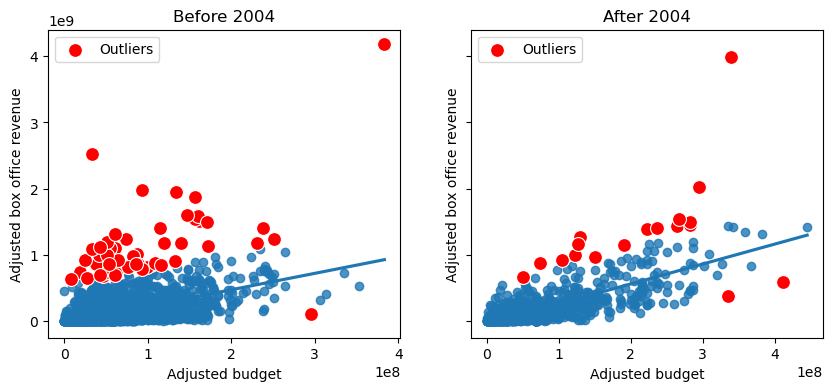

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

f, axes = plt.subplots(1, 2, sharey=True, figsize= (10, 4))


after = fixed_release_date[fixed_release_date['year'] < 2004]
after.fillna(after.mean(), inplace=True)

# Create a regression plot
reg_plot = sns.regplot(data=after, x='adjusted_budget', y='adjusted_box_office_revenue', ci=None, ax = axes[0])

# Get the regression line parameters
slope, intercept = np.polyfit(after['adjusted_budget'], after['adjusted_box_office_revenue'], 1)

# Calculate residuals
residuals = after['adjusted_box_office_revenue'] - (intercept + slope * after['adjusted_budget'])

# Identify points further than one standard deviation from the regression line
outliers = after[np.abs(residuals) > 3*np.std(residuals)]

# Highlight outliers in red with 'x' markers
sns.scatterplot(x='adjusted_budget', y='adjusted_box_office_revenue', data=outliers, color='red', s=100, label='Outliers', ax = axes[0])

axes[0].legend()
axes[0].set_title('Before 2004')
axes[0].set_xlabel('Adjusted budget')
axes[0].set_ylabel('Adjusted box office revenue')
# plt.show()

# Assuming you have a DataFrame named 'fixed_release_date'
after = fixed_release_date[fixed_release_date['year'] > 2004]
after.fillna(after.mean(), inplace=True)

# Create a regression plot
reg_plot = sns.regplot(data=after, x='adjusted_budget', y='adjusted_box_office_revenue', ci=None, ax = axes[1])

# Get the regression line parameters
slope, intercept = np.polyfit(after['adjusted_budget'], after['adjusted_box_office_revenue'], 1)

# Calculate residuals
residuals = after['adjusted_box_office_revenue'] - (intercept + slope * after['adjusted_budget'])

# Identify points further than one standard deviation from the regression line
outliers = after[np.abs(residuals) > 3*np.std(residuals)]

# Highlight outliers in red with 'x' markers
sns.scatterplot(x='adjusted_budget', y='adjusted_box_office_revenue', data=outliers, color='red', s=100, label='Outliers', ax = axes[1])

# plt.legend(loc='upper left')
axes[1].set_title('After 2004')
axes[1].set_xlabel('Adjusted budget')
axes[1].set_ylabel('Adjusted box office revenue')
plt.show()
